# COMP 4531 Final Project - Winter 2024

Team: Corey Munk and Kurt Meyer

Topic: Image Classification with the CIFAR-100 data set





# Load Packages and Data with some EDA

In [38]:
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier

from keras.datasets import cifar100
from keras.utils import to_categorical

from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [39]:
# Load CIFAR-100 data
(X, Y), (_, _) = cifar100.load_data() 

print(Y.shape)
print(X.shape)

(50000, 1)
(50000, 32, 32, 3)


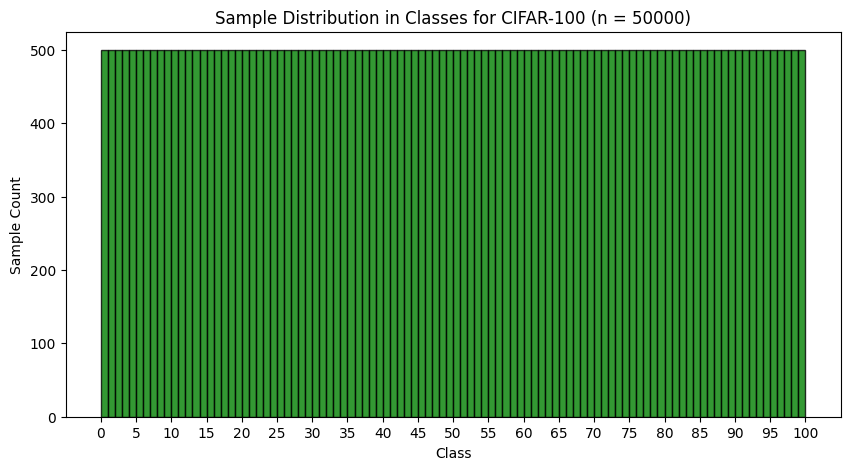

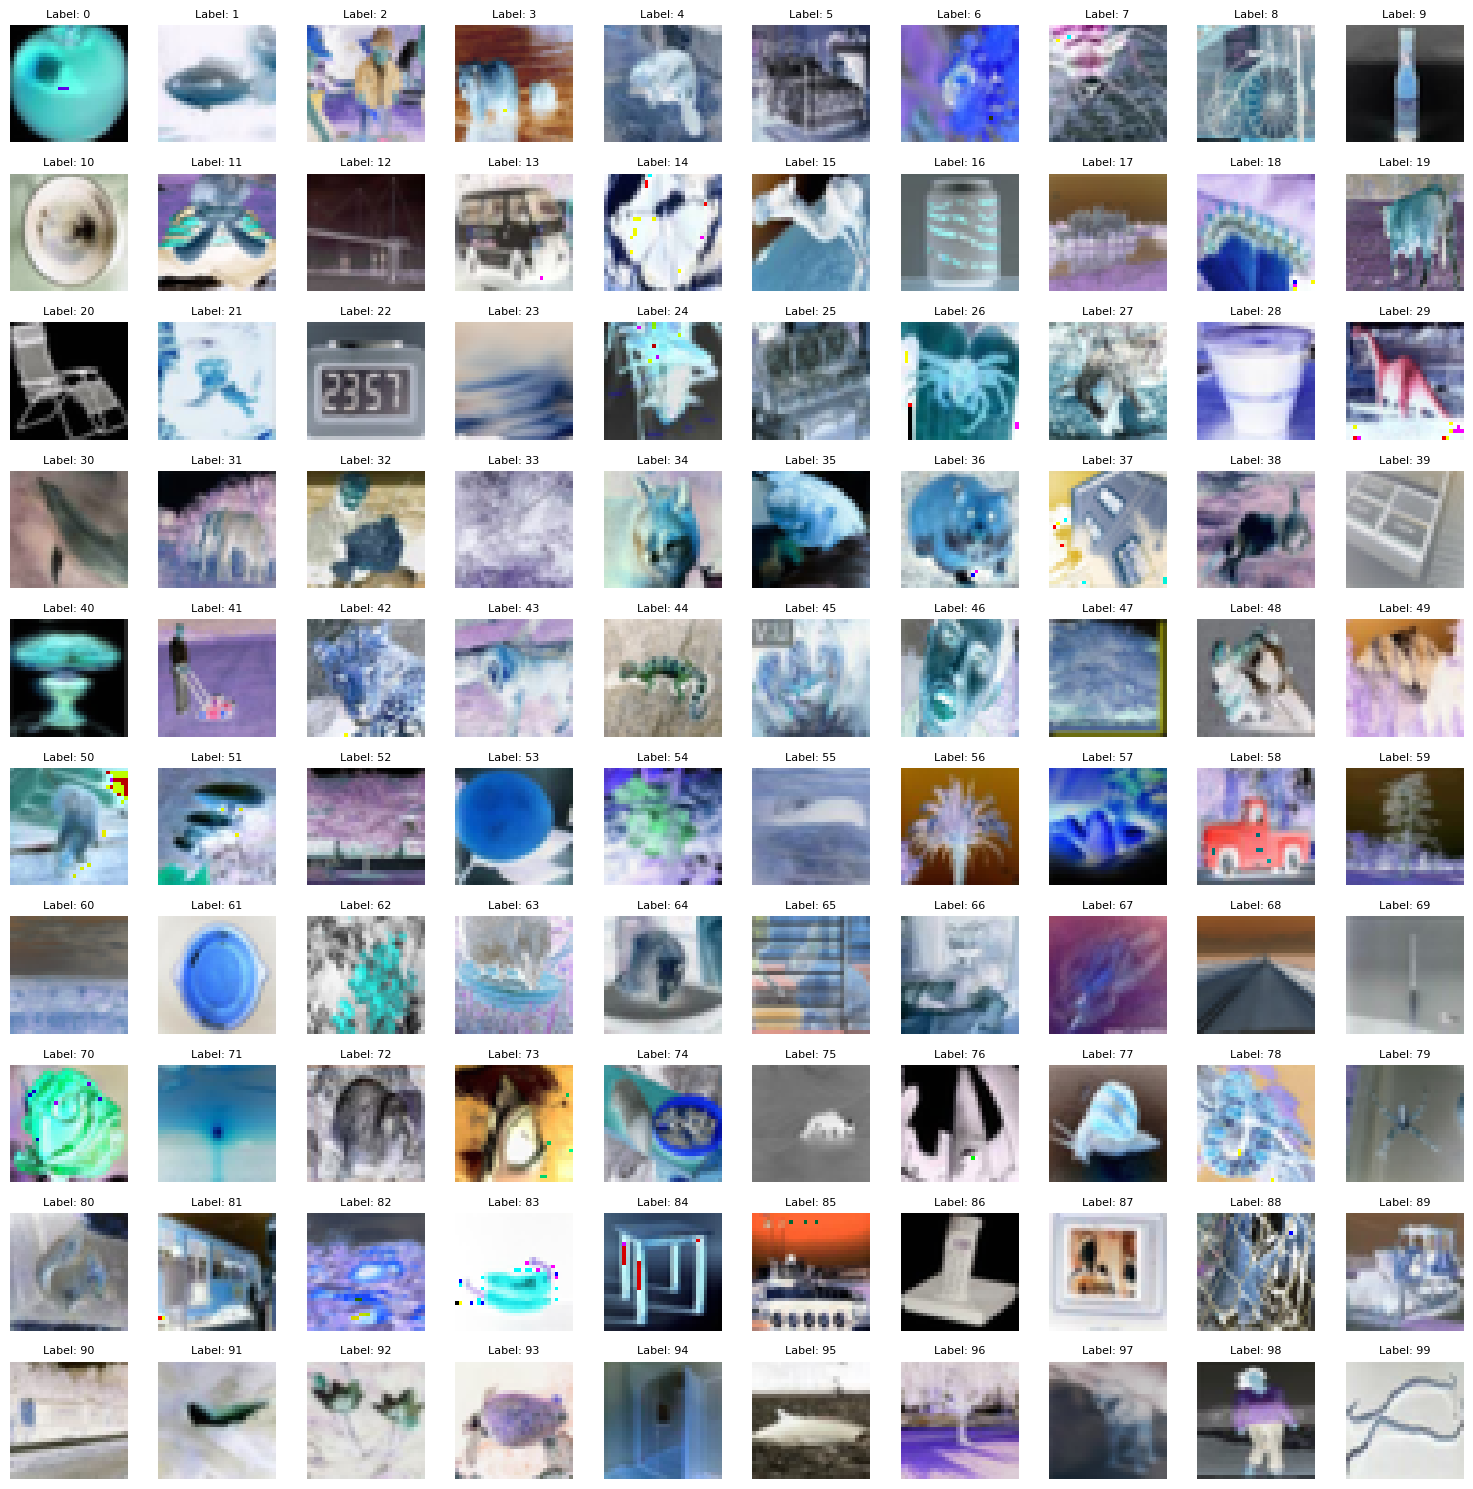

In [43]:
# Show sample count by label to visualize the balance of the data
class_labels = Y.flatten()

plt.figure(figsize=(10,5))
plt.hist(class_labels, bins=np.arange(0,101), alpha=.8, color='green', edgecolor='black')
plt.title(f'Sample Distribution in Classes for CIFAR-100 (n = {len(class_labels)})')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.xticks(np.arange(0,101, step=5))
plt.show()


# Display an image from each class in the dataset
distinct_labels = np.unique(Y)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i, label in enumerate(distinct_labels):
    # Get image and label
    idx = np.where(Y == label)[0]
    random_index = np.random.choice(idx)
    image, label = X[random_index], Y[random_index][0]
    
    # Define grid cell to place image
    row = i // 10
    col = i % 10
    
    # Display image in defined grid cell
    current_image = (image.reshape((32, 32, 3)) * 255).clip(0, 255).astype(int)
    axes[row, col].imshow(current_image, interpolation='nearest')
    axes[row, col].set_title(f"Label: {label}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# Data Processing

In [41]:
# Create train test splits
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=123, shuffle=True)

# Vectorize and normalize input images
X_train = (X_train.reshape(X_train.shape[0], -1)) / 255
X_test = (X_test.reshape(X_test.shape[0], -1)) / 255

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", Y_train.shape)
print("y_test:", Y_test.shape)

X_train: (40000, 3072)
X_test: (10000, 3072)
y_train: (40000, 1)
y_test: (10000, 1)


# Baseline Model Using Random Choice

In [42]:
# Create a random classifier
dummy_rand = DummyClassifier(strategy="uniform", random_state=123)

# Train the classifier
dummy_rand.fit(X_train, Y_train)

# Make predicitons
dummy_rand_preds = dummy_rand.predict(X_test)

# Calculate accuracy
baseline_accuracy_dummyrand = accuracy_score(Y_test, dummy_rand_preds)

print(f"Baseline accuracy for Random Dummy Classifier: {baseline_accuracy_dummyrand * 100}%")

Baseline accuracy for Random Dummy Classifier: 0.91%
